## GSE77940 

In [58]:
def collate_molgraphs(data):
    assert len(data[0]) in [5, 6], \
        'Expect the tuple to be of length 4 or 5, got {:d}'.format(len(data[0]))
    if len(data[0]) == 5:
        smiles, graphs,model_id, pathway, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, model_id, pathway, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    pathway = torch.stack(pathway, dim=0)
    labels = torch.stack(labels, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
    return smiles,  bg, model_id, pathway, labels, masks

In [59]:
from utils.featurizers import CanonicalAtomFeaturizer,CanonicalBondFeaturizer
from utils.csv_dataset import MoleculeCSVDataset
from functools import partial
from dgllife.utils import smiles_to_bigraph
import torch
from torch.utils.data import DataLoader
atom_featurizer = CanonicalAtomFeaturizer(atom_data_field='hv')
bond_featurizer = CanonicalBondFeaturizer(bond_data_field='he', self_loop=True)
def load_data(df1,df2,path,load,model_id):
    dataset = MoleculeCSVDataset(df1,df2,
                                 smiles_to_graph=partial(smiles_to_bigraph, add_self_loop='self_loop'),
                                 node_featurizer=atom_featurizer,
                                 edge_featurizer=bond_featurizer,
                                 smiles_column='SMILES',
                                 model_column=model_id,
                                 cache_file_path=path+ '_graph.bin',
                                 task_names=['label'],
                                 load=load,init_mask=True,n_jobs=16
                                 )

    return dataset

In [60]:
import pandas as pd
pathway_col = pd.read_csv('../XGraphCDS/Data/tcga/pathway_name.csv', index_col=0).index.tolist()
GSE77940_sets=pd.read_csv('../XGraphCDS/Data/tcga/GSE77940_drug_label.csv')
pathway_GSE77940= pd.read_csv('../XGraphCDS/Data/tcga/GSE77940_ssgesa.csv',index_col=0)
pathway_GSE77940=pathway_GSE77940[pathway_col].T
GSE77940_datasets = load_data(GSE77940_sets,pathway_GSE77940,'../XGraphCDS/Data/tcga/GSE77940',True,'patient_id')
GSE77940_loader = DataLoader(GSE77940_datasets,batch_size=128,shuffle=False,
                          collate_fn=collate_molgraphs)

Loading previously saved dgl graphs...


In [61]:
import torch.nn as nn
from utils.model_predictor import ModelPredictor
model = ModelPredictor(node_feat_size=atom_featurizer.feat_size('hv'),
                                       edge_feat_size=bond_featurizer.feat_size('he'),
                                       num_layers=2,
                                       num_timesteps=2,
                                       predictor_hidden_feats=128,
                                       graph_feat_size=256,
                                       #dropout=0.3,
                                       #predictor_dropout=0.3,
                                       n_tasks=1,
                                       kernel_size=5,
                                       hidden_channels=10)

fn = '../XGraphCDS/Models/tcga/0model.pth'
model.load_state_dict(torch.load(fn,map_location=torch.device('cpu')))
gcn_net = model

In [62]:
import numpy as np
import pandas as pd
from rdkit import Chem
from molvs.normalize import Normalizer, Normalization
from rdkit.Chem.SaltRemover import SaltRemover
from molvs.charge import Reionizer, Uncharger
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display
from sklearn import preprocessing
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams.update({"font.size":16})
plt.rcParams["font.weight"] = "bold"
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.unicode_minus'] = False

def draw(idx,model,datasets):
    model.eval()
    smiles, bg, model_id,  pathway,label, masks = datasets[idx]
    print(model_id,label)
    n_feats = bg.ndata.pop('hv')
    e_feats = bg.edata.pop('he')
    pathway=pathway.reshape(1,-1)
    logit, node_gradient,pes_gradient = model(bg, n_feats, e_feats,pathway,get_gradient=True)
    prob = torch.sigmoid(logit)
    pred = []
    for t in prob:
        if t >= 0.5:
            t = 1
            pred.append(t)
        if t < 0.5:
            t = 0
            pred.append(t)
    print(pred,prob)
    node_gradient = node_gradient.reshape(-1,1)
    node_gradient = preprocessing.MaxAbsScaler().fit_transform(node_gradient)
    node_gradients = torch.tensor(node_gradient)
    pes_gradient = pes_gradient.reshape(-1,1)
    pes_gradient = pes_gradient.detach().cpu().numpy()
    pes_gradient = preprocessing.MaxAbsScaler().fit_transform(pes_gradient)
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=max(node_gradient))
    cmap = cm.get_cmap('summer_r')
    plt_colors = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(node_gradients[i].data.item()) for i in range(bg.number_of_nodes())}
    plt_colors._A = [] 
    #cb = plt.colorbar(plt_colors) 
    #cb.set_ticks([]) 
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)   
    cbar=fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='summer_r'),cax=ax, orientation='horizontal', label='node gradient')
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('node gradient',fontsize=18)
    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(800,800)
    drawer.SetFontSize(20)
    op = drawer.drawOptions().addAtomIndices=True
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol,highlightAtoms=range(bg.number_of_nodes()),highlightBonds=[],
    highlightAtomColors=atom_colors,highlightAtomRadii={i: .4 for i in range(bg.number_of_nodes())})           
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .3
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    display(SVG(svg))
    return bg,pred,label,node_gradient,pes_gradient

Patient.1.Pre.RAF.MEKi tensor([1.])


D:\anaconda\envs\rdk\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[0] tensor([[0.4367]], grad_fn=<SigmoidBackward0>)


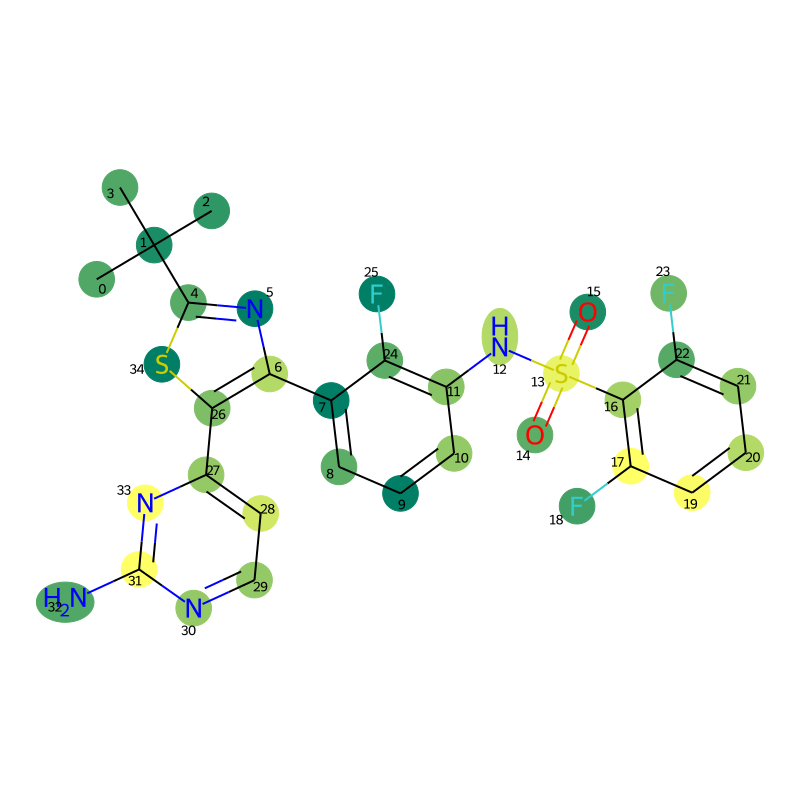

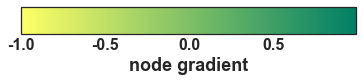

In [63]:
bg,pred,label,node_gradient,pes_gradient1=draw(0,gcn_net,GSE77940_datasets)

In [64]:
da=pd.DataFrame(pes_gradient1.reshape(-1),columns=['Pathway'])
da1=pd.concat([pd.read_csv('../XGraphCDS/Data/tcga/pathway_name.csv'),da],axis=1)
da2=da1.sort_values(by=['Pathway'],ascending=True).iloc[:30]
da3=da1.sort_values(by=['Pathway'],ascending=False).iloc[:30]

Patient.1.Post.RAF.MEKi tensor([0.])


D:\anaconda\envs\rdk\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[0] tensor([[7.5289e-26]], grad_fn=<SigmoidBackward0>)


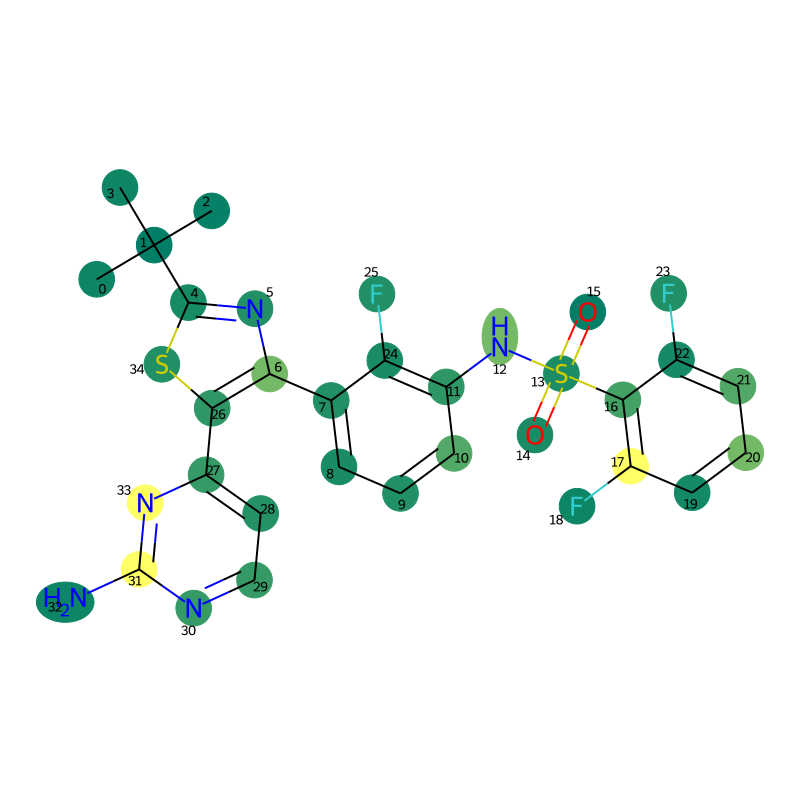

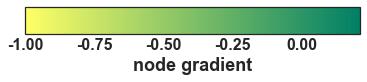

In [65]:
bg,pred,label,node_gradient,pes_gradient2=draw(2,gcn_net,GSE77940_datasets)

In [66]:
db=pd.DataFrame(pes_gradient2.reshape(-1),columns=['Pathway'])
db1=pd.concat([pd.read_csv('../XGraphCDS/Data/tcga/pathway_name.csv'),db],axis=1)
db2=db1.sort_values(by=['Pathway'],ascending=True).iloc[:30]
db3=db1.sort_values(by=['Pathway'],ascending=False).iloc[:30]

In [67]:
import numpy as np
from  scipy import stats
dc=pd.merge(da1,db1,on=['Unnamed: 0'],#dc_listings3，dc_listings4，on=['SMILES']，
             how='outer')
s,p=stats.ttest_1samp(dc['Pathway_x'].tolist(), dc['Pathway_y'].tolist())
dc['P_values']=pd.DataFrame(p.tolist())
#dc['log2foldchange']=pd.DataFrame(np.log2(dc['Pathway_x']+1)-np.log2(dc['Pathway_y']+1))
#dc['log2foldchange']=pd.DataFrame(np.log2(abs(dc['Pathway_x'])-dc['Pathway_y']))
dc['Delta']=pd.DataFrame(abs((dc['Pathway_y']-dc['Pathway_x'])/dc['Pathway_x']))
dc['-log10P']=pd.DataFrame(-np.log10(p))
types=[]
for i in dc['Delta'].tolist():
    if i >= 2:
        types.append('change (301)')
    else:
        types.append('no change (2697)')
print(len(types))
dc['Types']=pd.DataFrame(types)

2998


D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


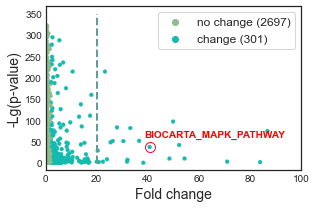

In [68]:
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-white')
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams.update({"font.size":14})
plt.rcParams["font.weight"] = "normal"
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
# 先设置一下自己的颜色
colors = ["darkseagreen", "#13bbaf","burlywood"]
sns.set_palette(sns.color_palette(colors))

# 绘图
fig, ax = plt.subplots(figsize=(4.5,3))
ax=sns.scatterplot(x='Delta', y='-log10P',data=dc,
                hue='Types',#颜色映射
                edgecolor = None,#点边界颜色
                s=15,#点大小
                )
# 标签
#ax.set_title("Python vocalno")
ax.set_xlabel("Fold change",fontdict=dict(size=14,weight='normal'))
ax.set_ylabel("-Lg(p-value)",fontdict=dict(size=14,weight='normal'))
ax.set_xlim([0, 100])
#移动图例位置
ax.legend(loc='best',fontsize=12,frameon=True)
ax.plot(40.732435, 37.248630, marker='o', markersize=10, markeredgecolor = (1, 0, 0.2, 1)
            ,markerfacecolor=(0, 0, 0, 0),)
ax.text(40.732435*0.95, 37.248630*1.6, 'BIOCARTA_MAPK_PATHWAY', fontsize=10,color = "r",family ='Arial',weight = "bold", 
        verticalalignment='baseline',horizontalalignment='left') 
ax.plot([20, 20], [0,350], 'k--',c='cadetblue',linewidth=2,alpha=1)
fig.tight_layout()
plt.show()

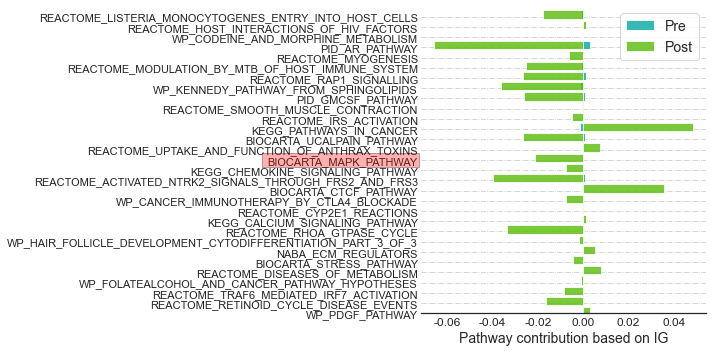

In [69]:
import matplotlib.pyplot as plt
#plt.style.use('seaborn-white')
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams.update({"font.size":10})
plt.rcParams["font.weight"] = "normal"
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.unicode_minus'] = False

dd=dc.sort_values(by=['Delta'],ascending=False).iloc[:30]

#perm_sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10,5))
tree_importance_sorted_idx1 = dd['Pathway_x'].tolist()
tree_importance_sorted_idx2 = dd['Pathway_y'].tolist()
labels1=dd['Unnamed: 0'].tolist()
tree_indices = np.arange(0, 30) + 0.2

ax.barh(tree_indices,tree_importance_sorted_idx1, 
         alpha=0.9,facecolor='lightseagreen',edgecolor='white',
        height=0.8)
ax.barh(tree_indices,tree_importance_sorted_idx2, 
         alpha=0.8,facecolor='#58bc08',edgecolor='white',height=0.8)
ax.text(-0.14, 14.8, '                                                                  ', 
        fontsize=8,color = "r",family ='Arial',weight = "bold", bbox=dict(facecolor="red", alpha=0.3), 
        verticalalignment='baseline',horizontalalignment='left') 
plt.yticks(range(len(labels1)),labels1,font={'family':'Arial', 'size':11})
plt.xticks(fontsize=12)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim((0, 30))
ax.legend(['Pre','Post'],loc='best',fontsize=14,frameon=True)
plt.grid(axis='y', linestyle='-.')
ax.set_xlabel('Pathway contribution based on IG',fontdict=dict(size=14,weight='normal') )
fig.tight_layout()
plt.show()